<a href="https://colab.research.google.com/github/nataliepham6720/10623-GenAI/blob/main/HW0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/10623/hw0

/content/drive/MyDrive/10623/hw0


In [3]:
ls

'Copy of S24 10-423 623 Recitation 0.ipynb'   HW0.ipynb              model.pth
 data/                                        image_classifier.txt   txt_classifier.py
 Homework-0.pdf                               img_classifiery.py     wandb/


Install and import necessary packages

In [4]:
# Install wandb
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [5]:
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from itertools import tee

import torch
import torch.nn as nn
from torch.autograd import Function
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image

## Image Classification

In [16]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image
import pandas as pd
import argparse

import wandb

# API Key is in your wandb settings
wandb.login(key="e60f8238b8524c195edde224c6b3f3e645648586")

img_size = (256,256)
num_labels = 3

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

class CsvImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if idx >= self.__len__(): raise IndexError()
        img_name = self.data_frame.loc[idx, "image"]
        image = Image.open(img_name).convert("RGB")  # Assuming RGB images
        label = self.data_frame.loc[idx, "label_idx"]

        if self.transform:
            image = self.transform(image)

        return image, label

def get_data(batch_size):
    transform_img = T.Compose([
        # T.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale image
        T.ToTensor(),
        # T.Resize((28,28)),  # Resize to tiny image of size 28 x 28
        T.Resize(min(img_size[0], img_size[1]), antialias=True),  # Resize the smallest side to 256 pixels
        T.CenterCrop(img_size),  # Center crop to 256x256
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize each color dimension
        # T.Normalize(mean=[0.485], std=[0.229])  # Normalize single-channel grayscale image
        ])

    train_data = CsvImageDataset(
        csv_file='./data/img_train.csv',
        transform=transform_img,
    )
    val_data = CsvImageDataset(
        csv_file='./data/img_val.csv',
        transform=transform_img,
    )
    test_data = CsvImageDataset(
        csv_file='./data/img_test.csv',
        transform=transform_img,
    )

    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    val_dataloader = DataLoader(val_data, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, batch_size=batch_size)

    for X, y in train_dataloader:
        print(f"Shape of X [B, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

    return train_dataloader, val_dataloader, test_dataloader

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        # First layer input size must be the dimension of the image
        self.linear_relu_stack = nn.Sequential(
            # nn.Linear(img_size[0] * img_size[1], 512), # for grayscale input
            # nn.Linear(28 * 28 * 3, 512), # for tiny input
            nn.Linear(img_size[0] * img_size[1] * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_labels)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        #self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, num_labels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # print(x.size())
        #x = self.relu(self.conv3(x))
        #x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_one_epoch(dataloader, model, loss_fn, optimizer, t):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss = loss.item() / batch_size
        current = (batch + 1) * dataloader.batch_size
        if batch % 10 == 0:
            print(f"Train loss = {loss:>7f}  [{current:>5d}/{size:>5d}]")

def evaluate(dataloader, dataname, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    avg_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avg_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_loss /= size
    correct /= size
    print(f"{dataname} accuracy = {(100*correct):>0.1f}%, {dataname} avg loss = {avg_loss:>8f}")
    return correct, avg_loss

# Assuming model_predictions contains the predictions of the model for the first batch
def log_images_with_labels(images, labels, model_predictions, dataset_type):
    for i in range(len(images)):
        predicted_label = model_predictions[i]
        true_label = labels[i]
        caption = f"{predicted_label} / {true_label}"

        # Log image with caption to wandb
        wandb.log({f"{dataset_type}_image_{i}": [wandb.Image(images[i], caption=caption)]})

def main(n_epochs, batch_size, learning_rate):
    print(f"Using {device} device")
    train_dataloader, val_dataloader, test_dataloader = get_data(batch_size)

    model = CNN().to(device)
    print(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    # optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate) # Adam optimizer with momentum

    # Initialize wandb run
    run = wandb.init(
        name = "CNN_sgd_1", # Enter useful info to prevent confusions
        reinit = True,
        project = "10-423-623 HW0", # Runs under the same project can be plotted together
    )

    # Save your network architecture as txt
    #network_architecture = open("image_classifier.txt", "w")
    #network_architecture.write(str(model))
    #network_architecture.close()

    # Log this file into wandb (or any other files you want to save in a similar manner)
    #wandb.save('image_classifier.txt')


    for t in range(n_epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, t)
        epoch_train_acc, epoch_train_loss = evaluate(train_dataloader, "Train", model, loss_fn)
        epoch_val_acc, epoch_val_loss = evaluate(val_dataloader, "Validation", model, loss_fn)

        # Log the loss and accuracy in wandb as well
        wandb.log({"Loss": epoch_val_loss, "Accuracy": epoch_val_acc})

        # Output test loss and accuracy
        epoch_test_acc, epoch_test_loss = evaluate(test_dataloader, "Test", model, loss_fn)

        # Uncomment to log the first batch of each of the datasets (train, val, test), on the last epoch only, images with a caption
        #class_names = ["parrot","narwhal","axolotl"]
        #dataset_types = ['train', 'val', 'test']
        #logs = [train_dataloader, val_dataloader, test_dataloader]
        # Log images with labels for the last epoch of testing
        #if t == n_epochs - 1:
        #    for i, ds in enumerate(logs):
        #        for batch, (X, y) in enumerate(ds):
        #            if batch == 0:
        #                X, y = X.to(device), y.to(device)
        #                pred = model(X)
        #                predicted_labels = [class_names[pred.item()] for pred in pred.argmax(1)]
        #                true_labels = [class_names[label.item()] for label in y]
        #                log_images_with_labels(X, true_labels, predicted_labels, dataset_type=dataset_types[i])

    print("Done!")


    # Save the model
    torch.save(model.state_dict(), "model.pth")
    #wandb.save('model.pth')
    print("Saved PyTorch Model State to model.pth")

    # Load the model (just for the sake of example)
    #model = NeuralNetwork().to(device)
    #model.load_state_dict(torch.load("model.pth"))

    # Finish your wandb run
    run.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [7]:
#if __name__ == '__main__':
#    parser = argparse.ArgumentParser(description = 'Image Classifier')
#    parser.add_argument('--n_epochs', default=5, help='The number of training epochs', type=int)
#    parser.add_argument('--batch_size', default=8, help='The batch size', type=int)
#    parser.add_argument('--learning_rate', default=1e-3, help='The learning rate for the optimizer', type=float)
#
#    args = parser.parse_args()
#
#    main(args.n_epochs, args.batch_size, args.learning_rate)

In [18]:
main(n_epochs=10, batch_size=8, learning_rate=1e-3)

Using cuda device
Shape of X [B, C, H, W]: torch.Size([8, 3, 256, 256])
Shape of y: torch.Size([8]) torch.int64
CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=524288, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (relu): ReLU()
)



Epoch 1
-------------------------------
Train loss = 0.136284  [    8/  540]
Train loss = 0.136572  [   88/  540]
Train loss = 0.124125  [  168/  540]
Train loss = 0.112861  [  248/  540]
Train loss = 0.094165  [  328/  540]
Train loss = 0.194504  [  408/  540]
Train loss = 0.140522  [  488/  540]
Train accuracy = 61.9%, Train avg loss = 0.102718
Validation accuracy = 62.1%, Validation avg loss = 0.103682
Test accuracy = 50.4%, Test avg loss = 0.120782

Epoch 2
-------------------------------
Train loss = 0.113140  [    8/  540]
Train loss = 0.107660  [   88/  540]
Train loss = 0.086344  [  168/  540]
Train loss = 0.087402  [  248/  540]
Train loss = 0.081804  [  328/  540]
Train loss = 0.210169  [  408/  540]
Train loss = 0.126671  [  488/  540]
Train accuracy = 66.3%, Train avg loss = 0.089240
Validation accuracy = 65.5%, Validation avg loss = 0.095579
Test accuracy = 53.0%, Test avg loss = 0.117076

Epoch 3
-------------------------------
Train loss = 0.098224  [    8/  540]
Train 

Accuracy,▁▄▆▆▇██▆▇█
Loss,█▅▃▂▁▁▁▂▃▄
Accuracy,0.7069
Loss,0.09089


## Text Classification

In [52]:
# From: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

import torch
import pandas as pd
import numpy as np
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch import nn
import time
import torchvision.transforms as T

import matplotlib.pyplot as plt

import wandb

# API Key is in your wandb settings
wandb.login(key="e60f8238b8524c195edde224c6b3f3e645648586")

# Hyperparameters
EPOCHS = 5  # epoch
LR = 5  # learning rate
BATCH_SIZE = 8  # batch size for training
EMBED_DIM = 64 # embedding size in model
HIDDEN_DIM = 128 # hidden size in model
MAX_LEN = 1024 # maximum text input length

# Get cpu, gpu device for training.
# mps does not (yet) support nn.EmbeddingBag.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

class CsvTextDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if idx >= self.__len__(): raise IndexError()
        text = self.data_frame.loc[idx, "article"]
        label = self.data_frame.loc[idx, "label_idx"]

        if self.transform:
            text = self.transform(text)

        return text, label

class CorpusInfo():
    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.oov_token = '<UNK>'
        self.pad_token = '<PAD>'

        def yield_tokens(data_iter):
            for text, _ in data_iter:
                yield tokenizer(text)
        self.vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=[self.oov_token, self.pad_token])
        self.vocab.set_default_index(self.vocab[self.oov_token])

        self.oov_idx = self.vocab[self.oov_token]
        self.pad_idx = self.vocab[self.pad_token]

        self.vocab_size = len(self.vocab)
        self.num_labels = len(set([label for (text, label) in dataset]))

class TextTransform(torch.Callable):
    def __init__(self, tokenizer, vocab):
        self.tokenizer = tokenizer
        self.vocab = vocab

    def tokenize_and_numericalize(self, text):
        tokens = self.tokenizer(text)
        return [self.vocab[token] for token in tokens]

    def __call__(self, text):
        return self.tokenize_and_numericalize(text)

class MaxLen(torch.Callable):
    def __init__(self, max_len):
        self.max_len = max_len

    def __call__(self, x):
        if len(x) > self.max_len:
            x = x[:self.max_len]
        return x

class PadSequence(torch.Callable):
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        def to_int_tensor(x):
            return torch.from_numpy(np.array(x, dtype=np.int64, copy=False))
        # Convert each sequence of tokens to a Tensor
        sequences = [to_int_tensor(x[0]) for x in batch]
        # Convert the full sequence of labels to a Tensor
        labels = to_int_tensor([x[1] for x in batch])
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
        return sequences_padded, labels

def get_data():
    train_data = CsvTextDataset(
        csv_file='./data/txt_train.csv',
        transform=None,
    )
    tokenizer = get_tokenizer("basic_english")
    corpus_info = CorpusInfo(train_data, tokenizer)
    # print(corpus_info)

    lengths = []
    for X, y in train_dataloader:
        # Assuming X contains the text data, calculate the length of each text
        for text in X:
            lengths.append(len(text.split()))  # Assuming the text is tokenized by whitespace

        # print(X[-1])

    # Plot histogram
    plt.hist(lengths, bins=50, color='blue', edgecolor='black')
    plt.title('Histogram of News Article Lengths')
    plt.xlabel('Length of News Articles')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    transform_txt = T.Compose([
        TextTransform(corpus_info.tokenizer, corpus_info.vocab),
        MaxLen(MAX_LEN),
    ])
    train_data = CsvTextDataset(
        csv_file='./data/txt_train.csv',
        transform=transform_txt,
    )
    val_data = CsvTextDataset(
        csv_file='./data/txt_val.csv',
        transform=transform_txt,
    )
    test_data = CsvTextDataset(
        csv_file='./data/txt_test.csv',
        transform=transform_txt,
    )

    collate_batch = PadSequence(corpus_info.pad_idx)
    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
    val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

    for X, y in train_dataloader:
        print(f"Shape of X [B, N]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

    return corpus_info, train_dataloader, val_dataloader, test_dataloader

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        return self.fc(embedded)

class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_output, _ = self.lstm(embedded)
        # Use the output of the last time step of the LSTM
        lstm_output_last = lstm_output[:, -1, :]
        return self.fc(lstm_output_last)


def train_one_epoch(dataloader, model, criterion, optimizer, epoch):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()

    for idx, (text, label) in enumerate(dataloader):
        text, label = text.to(device), label.to(device)
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader, model, criterion):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, label) in enumerate(dataloader):
            text, label = text.to(device), label.to(device)
            predicted_label = model(text)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

def main():
    corpus_info, train_dataloader, val_dataloader, test_dataloader = get_data()

    model = TextClassificationModel(corpus_info.vocab_size, EMBED_DIM, corpus_info.num_labels).to(device)
    # model = LSTM(corpus_info.vocab_size, EMBED_DIM, HIDDEN_DIM, corpus_info.num_labels).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    #optimizer = torch.optim.SGD(model.parameters(), lr=LR)
    #TODO:
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

    # Initialize wandb run
    #run = wandb.init(
    #    name = "text_classifier", # Enter useful info to prevent confusions
    #    reinit = True,
    #    project = "10-423-623 HW0", # Runs under the same project can be plotted together
    #)

    total_accu = None
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        train_one_epoch(train_dataloader, model, criterion, optimizer, epoch)
        accu_val = evaluate(val_dataloader, model, criterion)
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()
        else:
            total_accu = accu_val
        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, accu_val
            )
        )
        #wandb.log({"Accuracy": accu_val})
        print("-" * 59)

    # Evaluate some sample data
    for idx, (text, label) in enumerate(test_dataloader):
        text, label = text.to(device), label.to(device)
        if idx == 0:
            print('Sample test data: \n')
            print(text)
            predicted_label = model(text)
            print('Predicted label: ', predicted_label.argmax(1))
            print('True label: ', label)

    print("Checking the results of test dataset.")
    accu_test = evaluate(test_dataloader, model, criterion)
    print("test accuracy {:8.3f}".format(accu_test))

    # Save the model
    torch.save(model.state_dict(), "text_model.pth")
    #wandb.save('text_model.pth')
    print("Saved PyTorch Model State to text_model.pth")

    # Finish your wandb run
    #run.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


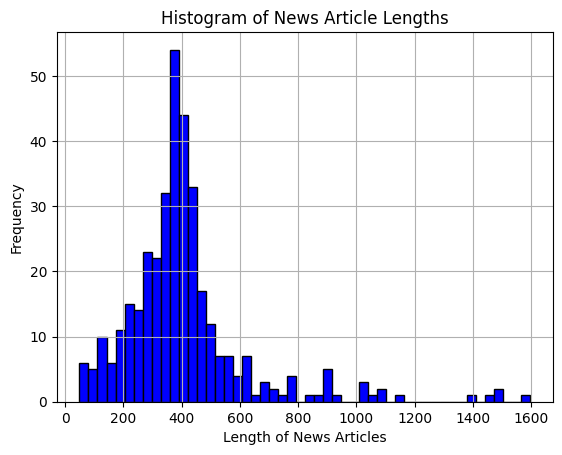

Shape of X [B, N]: torch.Size([8, 1024])
Shape of y: torch.Size([8]) torch.int64
| epoch   1 |     5/   45 batches | accuracy    0.500
| epoch   1 |    10/   45 batches | accuracy    0.375
| epoch   1 |    15/   45 batches | accuracy    0.700
| epoch   1 |    20/   45 batches | accuracy    0.450
| epoch   1 |    25/   45 batches | accuracy    0.650
| epoch   1 |    30/   45 batches | accuracy    0.700
| epoch   1 |    35/   45 batches | accuracy    0.675
| epoch   1 |    40/   45 batches | accuracy    0.775
-----------------------------------------------------------
| end of epoch   1 | time:  0.38s | valid accuracy    0.724 
-----------------------------------------------------------
| epoch   2 |     5/   45 batches | accuracy    0.771
| epoch   2 |    10/   45 batches | accuracy    0.575
| epoch   2 |    15/   45 batches | accuracy    0.725
| epoch   2 |    20/   45 batches | accuracy    0.650
| epoch   2 |    25/   45 batches | accuracy    0.750
| epoch   2 |    30/   45 batches | 

In [58]:
if __name__ == '__main__':
    main()